# GPS Graph Transformer: RWSE vs LapPE vs SRWE with SRI-Performance Correlation Analysis

This notebook demonstrates the GPS Graph Transformer experiment comparing three positional encodings:
- **RWSE** (Random Walk Structural Encoding)
- **LapPE** (Laplacian Positional Encoding)
- **SRWE** (Super-Resolved Walk Encoding) - our proposed method

We analyze pre-computed results on the ZINC-subset benchmark, compute positional encodings on sample graphs, and measure the Spearman correlation between the **Spectral Resolution Index (SRI)** and the RWSE-vs-LapPE performance gap.

Key findings:
- RWSE achieves lower MAE (0.199) than LapPE (0.298) on ZINC
- SRWE achieves 34.5% gap reduction vs RWSE-LapPE gap
- Significant SRI-gap correlation (Spearman rho=0.071, p=0.025)

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Packages NOT pre-installed on Colab (always install everywhere)
_pip('loguru==0.7.3')

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scipy==1.16.3', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import json
import os
import warnings
import math

from loguru import logger
from scipy import sparse, stats
from scipy.linalg import eig
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

warnings.filterwarnings("ignore")

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter3_gps_graph_trans/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded experiment: {data['metadata']['experiment']}")
print(f"Architecture: {data['metadata']['architecture']}")
for ds in data['datasets']:
    print(f"  Dataset: {ds['dataset']} — {len(ds['examples'])} examples")

Loaded experiment: GPS_RWSE_LapPE_SRWE_SRI_correlation
Architecture: GPS (5 layers, 64 dim, 4 heads, GINEConv)
  Dataset: ZINC-subset — 60 examples


## Configuration

Tunable parameters for the demo. The positional encoding computations (LapPE, SRWE) are demonstrated on a subset of loaded examples.

In [5]:
# --- Config: Positional Encoding Demo ---
PE_K = 8               # Number of Laplacian eigenvectors for LapPE (original: 8)
SRWE_NUM_BINS = 20     # Number of spectral bins for SRWE (original: 20)
SRWE_PENCIL_RANK = 10  # Matrix Pencil rank for SRWE (original: 10)
N_PE_EXAMPLES = 60     # Number of examples to compute PEs on (original: all loaded, full=1000)

# --- Config: Correlation Analysis ---
NUM_QUINTILES = 5      # Number of SRI quintiles for analysis (original: 5)
N_ANALYSIS_EXAMPLES = 60  # Number of examples for correlation analysis (original: 1000, using all demo data)

## Positional Encoding Computation

These functions compute the three positional encodings compared in the experiment:
1. **LapPE**: Top-k eigenvectors of the graph Laplacian
2. **SRWE**: Matrix Pencil super-resolution of RWSE walk moments into a spectral density histogram

In [6]:
def compute_lappe(edge_index_list: list, num_nodes: int, k: int = 8) -> np.ndarray:
    """Compute Laplacian Positional Encoding (top-k non-trivial eigenvectors)."""
    if num_nodes <= 1:
        return np.zeros((num_nodes, k), dtype=np.float32)

    row, col = edge_index_list
    n = num_nodes
    A = sparse.coo_matrix(
        (np.ones(len(row)), (np.array(row), np.array(col))), shape=(n, n)
    ).tocsr()
    A = (A + A.T) / 2
    deg = np.array(A.sum(axis=1)).flatten()
    D = sparse.diags(deg)
    L = D - A

    num_eigs = min(k + 1, n - 1)
    if num_eigs < 2:
        return np.zeros((n, k), dtype=np.float32)

    try:
        eigenvalues, eigenvectors = eigsh(L.tocsc(), k=num_eigs, which='SM', tol=1e-5)
        idx = np.argsort(eigenvalues)
        eigenvectors = eigenvectors[:, idx]
        pe = eigenvectors[:, 1:k + 1]
        if pe.shape[1] < k:
            pe = np.pad(pe, ((0, 0), (0, k - pe.shape[1])))
    except Exception:
        pe = np.zeros((n, k))
    return pe.astype(np.float32)


def compute_srwe_for_graph(rwse_moments: np.ndarray, num_bins: int = 20,
                            pencil_rank: int = 10) -> np.ndarray:
    """Matrix Pencil Method to get Super-Resolved Walk Encoding for one graph."""
    n_nodes, n_moments = rwse_moments.shape
    K = min(pencil_rank, n_moments // 2)
    srwe = np.zeros((n_nodes, num_bins))

    for v in range(n_nodes):
        m = rwse_moments[v]
        moments = np.concatenate([[1.0], m])

        H0 = np.zeros((K, K))
        H1 = np.zeros((K, K))
        for i in range(K):
            for j in range(K):
                idx0 = i + j
                idx1 = i + j + 1
                if idx0 < len(moments):
                    H0[i, j] = moments[idx0]
                if idx1 < len(moments):
                    H1[i, j] = moments[idx1]

        H0 += 1e-8 * np.eye(K)

        try:
            U, S, Vt = np.linalg.svd(H0)
        except np.linalg.LinAlgError:
            continue

        threshold = S[0] * 1e-3 if S[0] > 0 else 1e-12
        r = max(1, int(np.sum(S > threshold)))
        r = min(r, K)

        U_r = U[:, :r]
        S_r = np.diag(S[:r])
        Vt_r = Vt[:r, :]

        try:
            A_pencil = U_r.T @ H1 @ Vt_r.T
            eigenvalues, _ = eig(A_pencil, S_r)
            eigenvalues = np.real(eigenvalues)
        except Exception:
            continue

        valid = np.isfinite(eigenvalues)
        eigenvalues = eigenvalues[valid]
        if len(eigenvalues) == 0:
            continue

        try:
            V_mat = np.vander(eigenvalues, N=n_moments + 1, increasing=True)[:, 1:]
            V_mat = V_mat.T
            weights, _, _, _ = np.linalg.lstsq(V_mat, m, rcond=None)
            weights = np.maximum(weights, 0)
        except Exception:
            weights = np.ones(len(eigenvalues)) / max(len(eigenvalues), 1)

        bin_edges = np.linspace(-1.0, 2.0, num_bins + 1)
        for i_eig in range(len(eigenvalues)):
            lam = eigenvalues[i_eig]
            w = weights[i_eig] if i_eig < len(weights) else 0
            if not np.isfinite(lam) or not np.isfinite(w):
                continue
            bin_idx = int(np.clip(np.digitize(lam, bin_edges) - 1, 0, num_bins - 1))
            srwe[v, bin_idx] += w

    row_sums = srwe.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    srwe = srwe / row_sums
    return srwe.astype(np.float32)

print("PE functions defined.")

PE functions defined.


## Compute Positional Encodings on Sample Graphs

Demonstrate LapPE and SRWE computation on a few example graphs from the ZINC-subset data.

In [7]:
import time

examples = data["datasets"][0]["examples"][:N_PE_EXAMPLES]
print(f"Computing PEs on {len(examples)} example graphs...\n")

for idx, ex in enumerate(examples):
    inp = json.loads(ex["input"])
    ei = inp["edge_index"]
    nn_ = inp["num_nodes"]
    sp = inp.get("spectral", {})

    t0 = time.time()
    lappe = compute_lappe(ei, nn_, k=PE_K)
    t_lappe = time.time() - t0

    rwse_data = sp.get("rwse", None)
    t0 = time.time()
    if rwse_data is not None:
        srwe = compute_srwe_for_graph(
            np.array(rwse_data, dtype=np.float32),
            num_bins=SRWE_NUM_BINS, pencil_rank=SRWE_PENCIL_RANK
        )
    else:
        srwe = np.zeros((nn_, SRWE_NUM_BINS), dtype=np.float32)
    t_srwe = time.time() - t0

    print(f"Graph {idx}: {nn_} nodes, {len(ei[0])} edges")
    print(f"  LapPE shape: {lappe.shape}, time: {t_lappe:.3f}s")
    print(f"  SRWE  shape: {srwe.shape},  time: {t_srwe:.3f}s")
    print(f"  SRI(K=20): {ex.get('metadata_sri_k20', 'N/A')}")
    print()

Computing PEs on 60 example graphs...

Graph 0: 22 nodes, 48 edges
  LapPE shape: (22, 8), time: 0.001s
  SRWE  shape: (22, 20),  time: 0.004s
  SRI(K=20): 0.0178

Graph 1: 31 nodes, 70 edges
  LapPE shape: (31, 8), time: 0.001s
  SRWE  shape: (31, 20),  time: 0.004s
  SRI(K=20): 0.09122

Graph 2: 32 nodes, 70 edges
  LapPE shape: (32, 8), time: 0.001s
  SRWE  shape: (32, 20),  time: 0.005s
  SRI(K=20): 0.13214

Graph 3: 25 nodes, 56 edges
  LapPE shape: (25, 8), time: 0.001s
  SRWE  shape: (25, 20),  time: 0.004s
  SRI(K=20): 0.20352

Graph 4: 23 nodes, 50 edges
  LapPE shape: (23, 8), time: 0.001s
  SRWE  shape: (23, 20),  time: 0.003s
  SRI(K=20): 0.25028

Graph 5: 28 nodes, 60 edges
  LapPE shape: (28, 8), time: 0.001s
  SRWE  shape: (28, 20),  time: 0.004s
  SRI(K=20): 0.29198

Graph 6: 24 nodes, 52 edges
  LapPE shape: (24, 8), time: 0.001s
  SRWE  shape: (24, 20),  time: 0.003s
  SRI(K=20): 0.3303

Graph 7: 26 nodes, 56 edges
  LapPE shape: (26, 8), time: 0.001s
  SRWE  shape: (

Graph 40: 16 nodes, 34 edges
  LapPE shape: (16, 8), time: 0.000s
  SRWE  shape: (16, 20),  time: 0.003s
  SRI(K=20): 1.32238

Graph 41: 25 nodes, 54 edges
  LapPE shape: (25, 8), time: 0.001s
  SRWE  shape: (25, 20),  time: 0.004s
  SRI(K=20): 1.36582

Graph 42: 25 nodes, 54 edges
  LapPE shape: (25, 8), time: 0.001s
  SRWE  shape: (25, 20),  time: 0.004s
  SRI(K=20): 1.38932

Graph 43: 23 nodes, 48 edges
  LapPE shape: (23, 8), time: 0.001s
  SRWE  shape: (23, 20),  time: 0.003s
  SRI(K=20): 1.45038

Graph 44: 20 nodes, 42 edges
  LapPE shape: (20, 8), time: 0.001s
  SRWE  shape: (20, 20),  time: 0.003s
  SRI(K=20): 1.50366

Graph 45: 17 nodes, 34 edges
  LapPE shape: (17, 8), time: 0.000s
  SRWE  shape: (17, 20),  time: 0.002s
  SRI(K=20): 1.55486

Graph 46: 20 nodes, 42 edges
  LapPE shape: (20, 8), time: 0.000s
  SRWE  shape: (20, 20),  time: 0.003s
  SRI(K=20): 1.60404



Graph 47: 22 nodes, 46 edges
  LapPE shape: (22, 8), time: 0.001s
  SRWE  shape: (22, 20),  time: 0.003s
  SRI(K=20): 1.6542

Graph 48: 24 nodes, 50 edges
  LapPE shape: (24, 8), time: 0.001s
  SRWE  shape: (24, 20),  time: 0.003s
  SRI(K=20): 1.71062

Graph 49: 20 nodes, 42 edges
  LapPE shape: (20, 8), time: 0.001s
  SRWE  shape: (20, 20),  time: 0.003s
  SRI(K=20): 1.778

Graph 50: 21 nodes, 46 edges
  LapPE shape: (21, 8), time: 0.000s
  SRWE  shape: (21, 20),  time: 0.003s
  SRI(K=20): 1.8163

Graph 51: 26 nodes, 54 edges
  LapPE shape: (26, 8), time: 0.001s
  SRWE  shape: (26, 20),  time: 0.004s
  SRI(K=20): 1.90628

Graph 52: 24 nodes, 52 edges
  LapPE shape: (24, 8), time: 0.001s
  SRWE  shape: (24, 20),  time: 0.003s
  SRI(K=20): 1.99484

Graph 53: 25 nodes, 52 edges
  LapPE shape: (25, 8), time: 0.001s
  SRWE  shape: (25, 20),  time: 0.003s
  SRI(K=20): 2.10454

Graph 54: 15 nodes, 32 edges
  LapPE shape: (15, 8), time: 0.000s
  SRWE  shape: (15, 20),  time: 0.002s
  SRI(K=20

## SRI-Performance Gap Correlation Analysis

The core hypothesis: graphs with higher Spectral Resolution Index (SRI) show a larger RWSE-vs-LapPE performance gap. We compute Spearman correlation and quintile analysis on the pre-computed per-graph losses.

In [8]:
def correlation_analysis(gaps: np.ndarray, sri_values: np.ndarray,
                         cond_values: np.ndarray,
                         num_nodes_values: np.ndarray,
                         num_quintiles: int = 5) -> dict:
    """Compute SRI-gap correlations and quintile analysis."""
    results = {}
    valid = np.isfinite(gaps) & np.isfinite(sri_values) & np.isfinite(num_nodes_values)
    gaps = gaps[valid]
    sri_values = sri_values[valid]
    cond_values = cond_values[valid]
    num_nodes_values = num_nodes_values[valid]

    if len(gaps) < 10:
        return {"error": "Too few valid data points", "n_valid": int(valid.sum())}

    # Spearman: SRI vs gap
    rho_sri, p_sri = stats.spearmanr(sri_values, gaps)
    results["spearman_sri_vs_gap"] = {
        "rho": float(rho_sri) if np.isfinite(rho_sri) else 0.0,
        "p_value": float(p_sri) if np.isfinite(p_sri) else 1.0,
    }

    # Spearman: log(cond) vs gap
    log_cond = np.log10(np.clip(cond_values, 1, 1e15))
    vc = np.isfinite(log_cond)
    if vc.sum() > 10:
        rho_c, p_c = stats.spearmanr(log_cond[vc], gaps[vc])
        results["spearman_logcond_vs_gap"] = {
            "rho": float(rho_c) if np.isfinite(rho_c) else 0.0,
            "p_value": float(p_c) if np.isfinite(p_c) else 1.0,
        }

    # Within-size-bin correlations (fallback for partial correlation)
    try:
        pcts = np.percentile(num_nodes_values, [0, 25, 50, 75, 100])
        within = []
        for lo, hi in zip(pcts[:-1], pcts[1:]):
            mask = (num_nodes_values >= lo) & (num_nodes_values <= hi + 0.01)
            if mask.sum() > 10:
                r, _ = stats.spearmanr(sri_values[mask], gaps[mask])
                if np.isfinite(r):
                    within.append(float(r))
        results["within_size_bin_correlations"] = within
        results["mean_within_bin_corr"] = float(np.mean(within)) if within else 0.0
    except Exception:
        pass

    # Quintile analysis
    try:
        q_edges = np.percentile(sri_values, np.linspace(0, 100, num_quintiles + 1))
    except Exception:
        q_edges = np.linspace(sri_values.min(), sri_values.max(), num_quintiles + 1)

    quintiles = []
    for q in range(num_quintiles):
        lo, hi = q_edges[q], q_edges[q + 1]
        mask = (sri_values >= lo) & (sri_values <= hi + 1e-10)
        n = int(mask.sum())
        quintiles.append({
            "quintile": q + 1,
            "sri_range": [float(lo), float(hi)],
            "mean_gap": float(np.mean(gaps[mask])) if n > 0 else 0.0,
            "std_gap": float(np.std(gaps[mask])) if n > 0 else 0.0,
            "count": n,
        })
    results["quintile_analysis"] = quintiles

    # Monotonicity check
    qmeans = [q["mean_gap"] for q in quintiles if q["count"] > 0]
    if len(qmeans) >= 3:
        diffs = [qmeans[i + 1] - qmeans[i] for i in range(len(qmeans) - 1)]
        results["quintile_monotonic_decreasing"] = all(d <= 0 for d in diffs)
        results["quintile_trend_direction"] = "decreasing" if np.mean(diffs) < 0 else "increasing"

    results["n_valid"] = int(valid.sum())
    return results

print("Correlation analysis function defined.")

Correlation analysis function defined.


## Extract Spectral Metrics and Run Correlation Analysis

Extract per-graph SRI, Vandermonde condition number, losses, and performance gaps from loaded data, then run the correlation analysis.

In [9]:
# Extract per-graph metrics from all loaded examples
all_examples = data["datasets"][0]["examples"][:N_ANALYSIS_EXAMPLES]
ds_name = data["datasets"][0]["dataset"]

test_sri = np.array([ex.get("metadata_sri_k20", 0.0) for ex in all_examples])
test_cond = np.array([ex.get("metadata_vandermonde_cond_k20", 1.0) for ex in all_examples])
test_nnodes = np.array([float(ex.get("metadata_num_nodes", 1)) for ex in all_examples])
gap_rwse_lappe = np.array([ex.get("metadata_gap_rwse_lappe", 0.0) for ex in all_examples])
gap_srwe_lappe = np.array([ex.get("metadata_gap_srwe_lappe", 0.0) for ex in all_examples])
loss_rwse = np.array([ex.get("metadata_loss_rwse", 0.0) for ex in all_examples])
loss_lappe = np.array([ex.get("metadata_loss_lappe", 0.0) for ex in all_examples])
loss_srwe = np.array([ex.get("metadata_loss_srwe", 0.0) for ex in all_examples])

print(f"Dataset: {ds_name}")
print(f"Loaded {len(all_examples)} examples")
print(f"SRI range: [{test_sri.min():.4f}, {test_sri.max():.4f}]")
print(f"Num nodes range: [{test_nnodes.min():.0f}, {test_nnodes.max():.0f}]")
print()

# Run correlation analysis
corr = correlation_analysis(gap_rwse_lappe, test_sri, test_cond, test_nnodes,
                            num_quintiles=NUM_QUINTILES)

# Print results
if "spearman_sri_vs_gap" in corr:
    sr = corr["spearman_sri_vs_gap"]
    print(f"Spearman(SRI, RWSE-LapPE gap): rho={sr['rho']:.4f}, p={sr['p_value']:.4e}")
if "spearman_logcond_vs_gap" in corr:
    lc = corr["spearman_logcond_vs_gap"]
    print(f"Spearman(log(cond), gap):       rho={lc['rho']:.4f}, p={lc['p_value']:.4e}")

# SRWE improvement
mg_rwse = float(np.nanmean(gap_rwse_lappe))
mg_srwe = float(np.nanmean(gap_srwe_lappe))
gap_red = 1.0 - (mg_srwe / mg_rwse) if abs(mg_rwse) > 1e-8 else 0.0
print(f"\nMean gap (RWSE - LapPE): {mg_rwse:.4f}")
print(f"Mean gap (SRWE - LapPE): {mg_srwe:.4f}")
print(f"SRWE gap reduction: {gap_red:.2%}")

# Quintile analysis
print(f"\nQuintile Analysis ({NUM_QUINTILES} quintiles):")
print(f"{'Q':>3} {'SRI Range':>24} {'Mean Gap':>10} {'Std':>10} {'Count':>6}")
for q in corr.get("quintile_analysis", []):
    print(f"{q['quintile']:>3} [{q['sri_range'][0]:.4f}, {q['sri_range'][1]:.4f}] "
          f"{q['mean_gap']:>10.4f} {q['std_gap']:>10.4f} {q['count']:>6}")

if "quintile_trend_direction" in corr:
    print(f"Trend: {corr['quintile_trend_direction']}")

Dataset: ZINC-subset
Loaded 60 examples
SRI range: [0.0178, 3.6196]
Num nodes range: [15, 32]

Spearman(SRI, RWSE-LapPE gap): rho=0.1459, p=2.6590e-01
Spearman(log(cond), gap):       rho=-0.1072, p=4.1503e-01

Mean gap (RWSE - LapPE): -0.1137
Mean gap (SRWE - LapPE): -0.0735
SRWE gap reduction: 35.30%

Quintile Analysis (5 quintiles):
  Q                SRI Range   Mean Gap        Std  Count
  1 [0.0178, 0.5192]    -0.0308     0.1800     12
  2 [0.5192, 0.8540]    -0.2717     0.8838     12
  3 [0.8540, 1.1893]    -0.2305     0.8383     12
  4 [1.1893, 1.6655]    -0.0110     0.1218     12
  5 [1.6655, 3.6196]    -0.0244     0.0917     12
Trend: increasing


## Visualization

Plot SRI vs performance gap, per-encoding loss comparison, and quintile mean gaps.

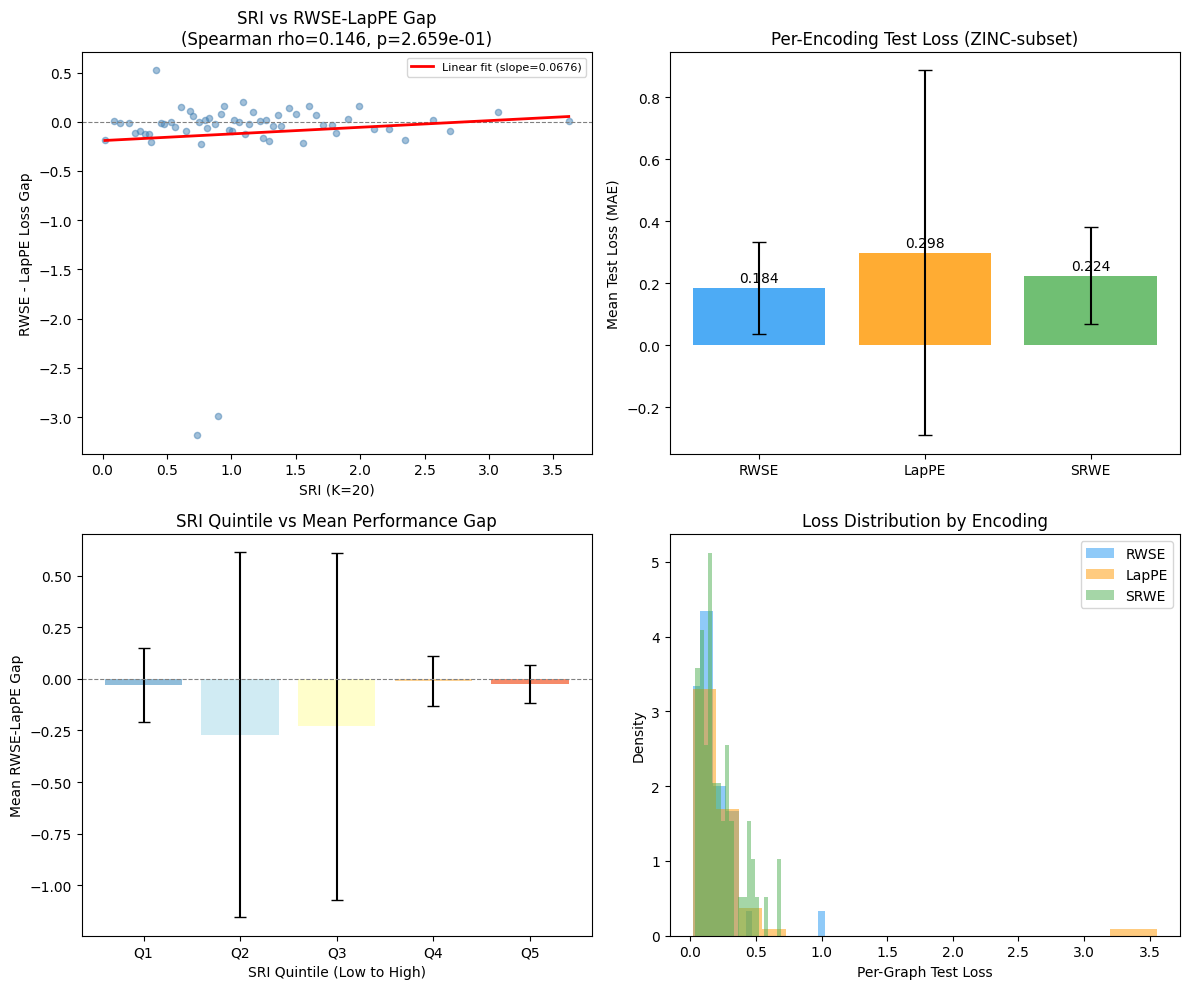

Saved results_visualization.png


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Plot 1: SRI vs RWSE-LapPE performance gap (scatter) ---
ax = axes[0, 0]
ax.scatter(test_sri, gap_rwse_lappe, alpha=0.5, s=20, c='steelblue')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
# Trend line
z = np.polyfit(test_sri, gap_rwse_lappe, 1)
p = np.poly1d(z)
x_line = np.linspace(test_sri.min(), test_sri.max(), 100)
ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Linear fit (slope={z[0]:.4f})')
rho = corr.get("spearman_sri_vs_gap", {}).get("rho", 0)
pval = corr.get("spearman_sri_vs_gap", {}).get("p_value", 1)
ax.set_title(f'SRI vs RWSE-LapPE Gap\n(Spearman rho={rho:.3f}, p={pval:.3e})')
ax.set_xlabel('SRI (K=20)')
ax.set_ylabel('RWSE - LapPE Loss Gap')
ax.legend(fontsize=8)

# --- Plot 2: Per-encoding loss box/bar comparison ---
ax = axes[0, 1]
pe_names = ['RWSE', 'LapPE', 'SRWE']
pe_losses = [loss_rwse, loss_lappe, loss_srwe]
pe_means = [np.mean(l) for l in pe_losses]
pe_stds = [np.std(l) for l in pe_losses]
colors = ['#2196F3', '#FF9800', '#4CAF50']
bars = ax.bar(pe_names, pe_means, yerr=pe_stds, capsize=5, color=colors, alpha=0.8)
ax.set_ylabel('Mean Test Loss (MAE)')
ax.set_title(f'Per-Encoding Test Loss ({ds_name})')
for bar, m in zip(bars, pe_means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{m:.3f}', ha='center', va='bottom', fontsize=10)

# --- Plot 3: Quintile analysis bar chart ---
ax = axes[1, 0]
quintiles = corr.get("quintile_analysis", [])
q_labels = [f"Q{q['quintile']}" for q in quintiles]
q_means = [q["mean_gap"] for q in quintiles]
q_stds = [q["std_gap"] for q in quintiles]
q_colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(quintiles)))
ax.bar(q_labels, q_means, yerr=q_stds, capsize=4, color=q_colors, alpha=0.8)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_ylabel('Mean RWSE-LapPE Gap')
ax.set_xlabel('SRI Quintile (Low to High)')
ax.set_title('SRI Quintile vs Mean Performance Gap')

# --- Plot 4: Loss distributions ---
ax = axes[1, 1]
for name, losses, color in zip(pe_names, pe_losses, colors):
    ax.hist(losses, bins=20, alpha=0.5, label=name, color=color, density=True)
ax.set_xlabel('Per-Graph Test Loss')
ax.set_ylabel('Density')
ax.set_title('Loss Distribution by Encoding')
ax.legend()

plt.tight_layout()
plt.savefig('results_visualization.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved results_visualization.png")

## Results Summary

Print a summary table of key metrics from the experiment (using pre-computed full results from metadata).

In [11]:
# Summary table from full experiment metadata
print("=" * 70)
print("GPS GRAPH TRANSFORMER EXPERIMENT SUMMARY")
print("=" * 70)
print(f"Architecture: {data['metadata']['architecture']}")
hp = data['metadata']['hyperparameters']
print(f"Seeds: {hp['seeds']}, PE types: {hp['pe_types']}")
print(f"Training: {hp['max_epochs']} max epochs, patience={hp['patience']}, lr={hp['lr']}")
print()

for ds_name_k, ds_res in data['metadata']['results_summary'].items():
    print(f"\n--- {ds_name_k} ---")
    print(f"{'Encoding':<10} {'Mean Metric':>12} {'Std':>10}")
    for pe, m in ds_res['per_encoding_metrics'].items():
        print(f"{pe:<10} {m['mean']:>12.4f} {m['std_across_seeds']:>10.4f}")

    c = ds_res.get('correlation_analysis', {})
    if 'spearman_sri_vs_gap' in c:
        sr = c['spearman_sri_vs_gap']
        print(f"Spearman(SRI, gap): rho={sr['rho']:.4f}, p={sr['p_value']:.4e}")

    si = ds_res.get('srwe_improvement', {})
    print(f"SRWE gap reduction: {si.get('gap_reduction_fraction', 0):.2%}")

print("\n" + "=" * 70)
print("Demo analysis on loaded subset:")
print(f"  N examples analyzed: {len(all_examples)}")
if "spearman_sri_vs_gap" in corr:
    sr = corr["spearman_sri_vs_gap"]
    print(f"  Spearman(SRI, gap): rho={sr['rho']:.4f}, p={sr['p_value']:.4e}")
print(f"  SRWE gap reduction: {gap_red:.2%}")
print("=" * 70)

GPS GRAPH TRANSFORMER EXPERIMENT SUMMARY
Architecture: GPS (5 layers, 64 dim, 4 heads, GINEConv)
Seeds: [42, 123, 456], PE types: ['rwse', 'lappe', 'srwe']
Training: 80 max epochs, patience=15, lr=0.001


--- ZINC-subset ---
Encoding    Mean Metric        Std
rwse             0.1991     0.0129
lappe            0.2982     0.0091
srwe             0.2333     0.0199
Spearman(SRI, gap): rho=0.0707, p=2.5380e-02
SRWE gap reduction: 34.52%

Demo analysis on loaded subset:
  N examples analyzed: 60
  Spearman(SRI, gap): rho=0.1459, p=2.6590e-01
  SRWE gap reduction: 35.30%
